# PyTorch Experiment Tracking

We gonna make our first milestone project 

FoodVision Mini Experiment Tracking

## What is Experiment tracking?

machine and deep learning are very experimental.

this it is really important to keep track of results of diff combination of data, architecture and training regime.

##  But why?

if we using a handful number of models, it might be okay just to track their results in print statements and a few dictionaries.

## diff ways

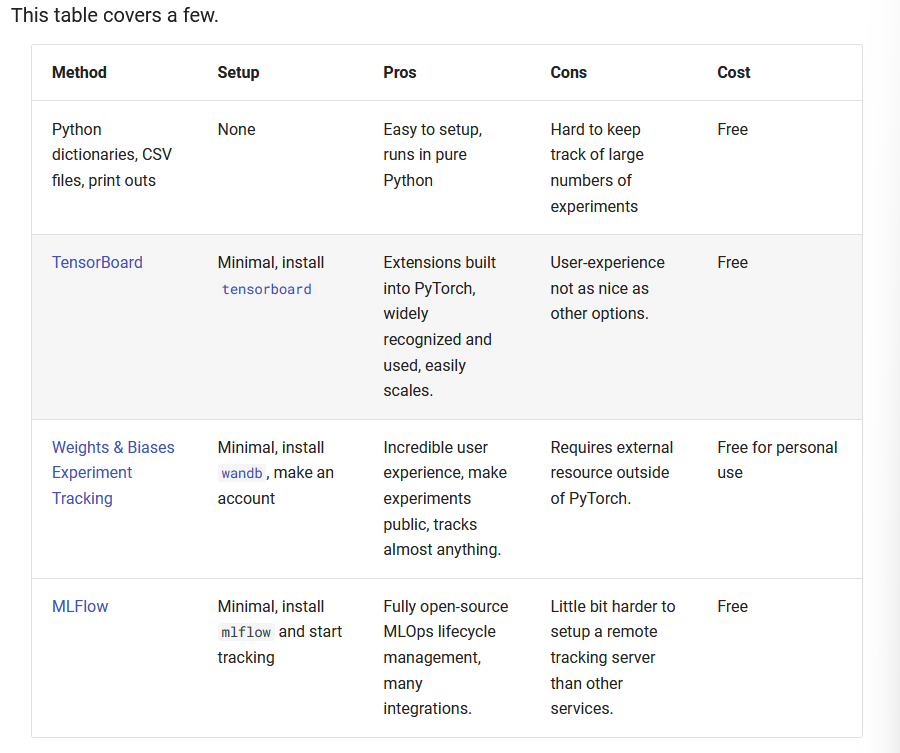

## 0. Getting Setup

Let's start by downloading all the modules we'll need for this section.

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

from torchinfo import summary

from going_modular.going_modular import data_setup, engine

device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\Anubhav\miniconda3\envs\nn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

#### Create helper function to set seeds

setting seeds is imp and you are using it a lot so making a function is beneficial.

In [3]:
def set_seeds(seed: int = 42):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## 1. Get Data


lets functionize this for better re-usability

In [4]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] directory already exists so skipping download.")
    else:
        print(f"[INFO] Did not find directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] directory already exists so skipping download.


WindowsPath('data/pizza_steak_sushi')

## 2. Create datasets and dataloaders

we can use auto or manual transforms. lets do auto

In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

auto_transforms = weights.transforms()

train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir= test_dir,
    transform= auto_transforms,
    batch_size= 32,
    num_workers= 0
)

train_dataloaders, test_dataloaders, class_names

(<torch.utils.data.dataloader.DataLoader at 0x11f2573dc90>,
 ['pizza', 'steak', 'sushi'])

## 3. getting a pretrained model and freezing its layers and changing classifier head

In [6]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
for param in model.features.parameters():
    param.requires_grad = False

set_seeds()

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2 , inplace = True),
    nn.Linear(in_features= 1280, 
              out_features= 3,
              bias= True)
).to(device)

In [8]:
from torchinfo import summary

summary(model, 
        (32,3,224,224), 
        verbose= 0, 
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model and track results

In [9]:
# loss and optim

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Now we need to adjust `train()` function to track results with `summarywriter()`

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [11]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step


def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
                    }

    
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model,
                                           train_dataloader,
                                           loss_fn,
                                           optimizer,
                                           device)
        
        test_loss, test_acc = test_step(model,
                                        test_dataloader,
                                        loss_fn,
                                        device)
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        writer.add_scalars(main_tag= "Loss",
                           tag_scalar_dict= {"train_loss": train_loss,
                                             "test_loss": test_loss},
                                             global_step=epoch)
        
        writer.add_scalars(main_tag= "Accuracy",
                           tag_scalar_dict= {"train_acc": train_acc,
                                             "test_acc": test_acc},
                                             global_step=epoch)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32,3,224,224).to(device))
        

        writer.close()


        return results

        



In [12]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [13]:
# train model

set_seeds(42)

results = train(model,
                train_dataloaders,
                test_dataloaders,
                optimizer,
                loss_fn,
                epochs=5,
                device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3906 | test_loss: 0.9144 | test_acc: 0.5909


 20%|██        | 1/5 [00:05<00:22,  5.65s/it]

Epoch: 2 | train_loss: 0.9046 | train_acc: 0.6445 | test_loss: 0.7883 | test_acc: 0.8258


 40%|████      | 2/5 [00:10<00:16,  5.45s/it]

Epoch: 3 | train_loss: 0.8096 | train_acc: 0.7344 | test_loss: 0.6768 | test_acc: 0.8864


 60%|██████    | 3/5 [00:16<00:10,  5.31s/it]

Epoch: 4 | train_loss: 0.6849 | train_acc: 0.8633 | test_loss: 0.6739 | test_acc: 0.8049


 80%|████████  | 4/5 [00:21<00:05,  5.37s/it]

Epoch: 5 | train_loss: 0.7080 | train_acc: 0.7266 | test_loss: 0.6793 | test_acc: 0.7737


100%|██████████| 5/5 [00:27<00:00,  5.46s/it]


In [14]:
results

{'train_loss': [1.0961915776133537,
  0.904602937400341,
  0.8096262142062187,
  0.6848723366856575,
  0.7079544439911842],
 'train_acc': [0.390625, 0.64453125, 0.734375, 0.86328125, 0.7265625],
 'test_loss': [0.914383331934611,
  0.7883057594299316,
  0.6768300334612528,
  0.6739227573076884,
  0.6792691548665365],
 'test_acc': [0.5909090909090909,
  0.8257575757575758,
  0.8863636363636364,
  0.8049242424242425,
  0.7736742424242425]}

In [15]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 20076), started 9 days, 4:49:10 ago. (Use '!kill 20076' to kill it.)

## 6. Create a helper function to build `SummaryWriter()` 


we'd like to track things like:

   * Experiment date/timestamp - when did the experiment take place?
  *  Experiment name - is there something we'd like to call the experiment?
 *   Model name - what model was used?
*    Extra - should anything else be tracked?


In [16]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():

    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [17]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_10_percent\effnetb0\5_epochs...


### 6.1 update train function to include a parameter

In [18]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:

    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]
               }
    
    for epoch in tqdm(range(epochs)):

        train_loss , train_acc = train_step(model = model,
                                            dataloader= train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device = device)
        
        test_loss, test_acc = test_step(model= model, 
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device= device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

                ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

        

## 7. Setup a series of modelling experiments


### 7.1 Types of experiments we can do


Every hyperparameter stands as a starting point for a different experiment:

* Change the number of epochs.
* Change the number of layers/hidden units.
* Change the amount of data.
* Change the learning rate.
* Try different kinds of data augmentation.
* Choose a different model architecture.



### 7.2 exp we are doing


1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model (torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
3. A different training time (5 epochs vs. 10 epochs)




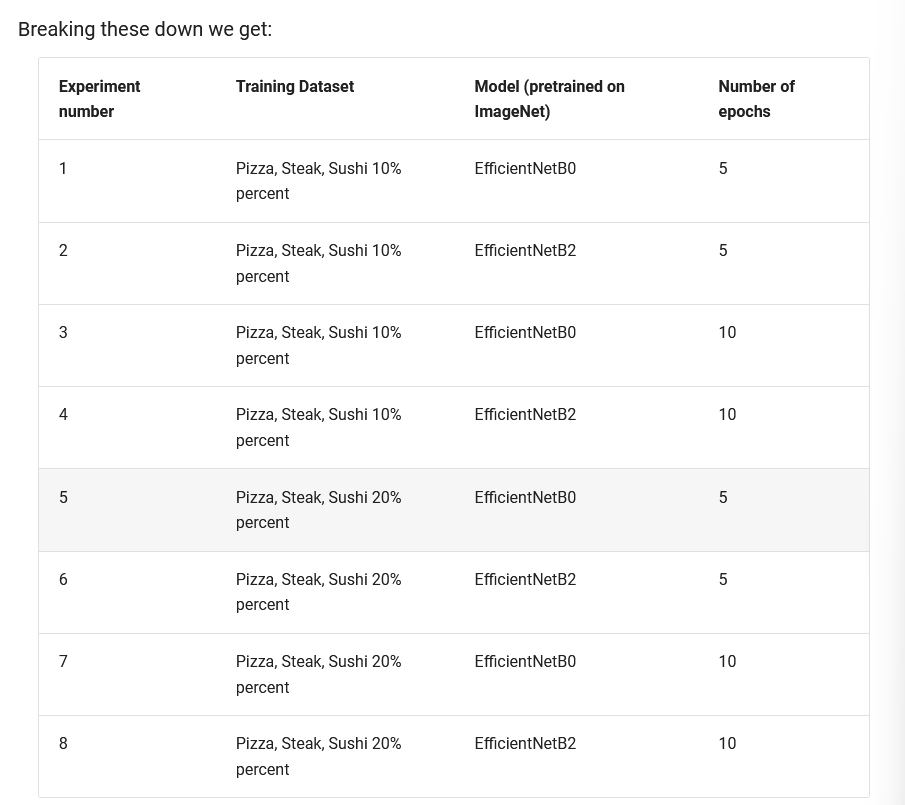

### 7.3 Download different datasets


In [19]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] directory already exists so skipping download.
[INFO] directory already exists so skipping download.


In [20]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


### 7.4 Transform Datasets and create DataLoaders

1. resize all to 244,244
2. Turn to tensors
3. Normalize

In [21]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [22]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create Feature extractor models

We're going to create two feature extractor models:

*    `torchvision.models.efficientnet_b0()` pretrained backbone + custom classifier head (EffNetB0 for short).
*    `torchvision.models.efficientnet_b2()` pretrained backbone + custom classifier head (EffNetB2 for short).





In [23]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [24]:
effnetb0 = create_effnetb0()
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.


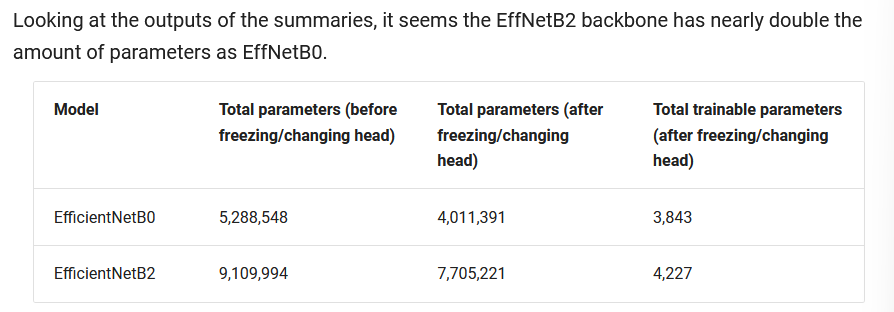

### 7.6 Create experiments and set up training code

1. A list of number of epochs we'd like
2. A list of models we'd like to test ["effnetb0", "effnetb2"]
3. a dictionary of different training dataloaders.

In [25]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

Now we can write code to iterate through each of the different options and try out each of the different combinations.

We'll also save the model at the end of each experiment so later on we can load back in the best model and use it for making predictions.

Specifically, let's go through the following steps:

*    Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
*    Keep track of different experiment numbers (this is mostly for pretty print outs).
*    Loop through the train_dataloaders dictionary items for each of the different training DataLoaders.
*    Loop through the list of epoch numbers.
*    Loop through the list of different model names.
*    Create information print outs for the current running experiment (so we know what's happening).
*    Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
*    Create a new loss function (torch.nn.CrossEntropyLoss()) and optimizer (torch.optim.Adam(params=model.parameters(), lr=0.001)) for each new experiment.
*    Train the model with the modified train() function passing the appropriate details to the writer parameter.
*    Save the trained model with an appropriate file name to file with save_model() from utils.py.


In [26]:
%%time

from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 8.1 Compile model (feature of torch 2.0+)

            # model = torch.compile(model)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_10_percent\effnetb0\5_epochs...


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9218 | test_acc: 0.4678


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7174 | test_acc: 0.8258


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

Epoch: 4 | train_loss: 0.7097 | train_acc: 0.7578 | test_loss: 0.5897 | test_acc: 0.8864


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_10_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:02<00:11,  2.89s/it]

Epoch: 1 | train_loss: 1.0927 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_10_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [00:02<00:18,  2.03s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9218 | test_acc: 0.4678


 20%|██        | 2/10 [00:04<00:18,  2.30s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203


 30%|███       | 3/10 [00:06<00:15,  2.21s/it]

Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7174 | test_acc: 0.8258


 40%|████      | 4/10 [00:08<00:12,  2.14s/it]

Epoch: 4 | train_loss: 0.7097 | train_acc: 0.7578 | test_loss: 0.5897 | test_acc: 0.8864


 50%|█████     | 5/10 [00:10<00:10,  2.11s/it]

Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864


 60%|██████    | 6/10 [00:12<00:08,  2.10s/it]

Epoch: 6 | train_loss: 0.5611 | train_acc: 0.8984 | test_loss: 0.5949 | test_acc: 0.8864


 70%|███████   | 7/10 [00:14<00:06,  2.11s/it]

Epoch: 7 | train_loss: 0.5574 | train_acc: 0.7930 | test_loss: 0.5566 | test_acc: 0.8864


 80%|████████  | 8/10 [00:17<00:04,  2.12s/it]

Epoch: 8 | train_loss: 0.4702 | train_acc: 0.9492 | test_loss: 0.5177 | test_acc: 0.8759


 90%|█████████ | 9/10 [00:19<00:02,  2.11s/it]

Epoch: 9 | train_loss: 0.5728 | train_acc: 0.7773 | test_loss: 0.5094 | test_acc: 0.8873


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

Epoch: 10 | train_loss: 0.4794 | train_acc: 0.8242 | test_loss: 0.4640 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_10_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:02<00:20,  2.23s/it]

Epoch: 1 | train_loss: 1.0927 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 20%|██        | 2/10 [00:04<00:17,  2.17s/it]

Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 30%|███       | 3/10 [00:06<00:14,  2.13s/it]

Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176


 40%|████      | 4/10 [00:08<00:12,  2.13s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081


 50%|█████     | 5/10 [00:10<00:10,  2.14s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873


 60%|██████    | 6/10 [00:12<00:08,  2.14s/it]

Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6325 | test_acc: 0.9280


 70%|███████   | 7/10 [00:15<00:06,  2.14s/it]

Epoch: 7 | train_loss: 0.6127 | train_acc: 0.8008 | test_loss: 0.6403 | test_acc: 0.8769


 80%|████████  | 8/10 [00:17<00:04,  2.15s/it]

Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6199 | test_acc: 0.8977


 90%|█████████ | 9/10 [00:19<00:02,  2.21s/it]

Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6225 | test_acc: 0.8769


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]

Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_20_percent\effnetb0\5_epochs...


 20%|██        | 1/5 [00:04<00:18,  4.54s/it]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6167 | test_loss: 0.6545 | test_acc: 0.8655


 40%|████      | 2/5 [00:08<00:13,  4.40s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176


 60%|██████    | 3/5 [00:12<00:07,  4.00s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176


 80%|████████  | 4/5 [00:15<00:03,  3.84s/it]

Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4459 | test_acc: 0.9176


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3908 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_20_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:04<00:18,  4.57s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7767 | test_acc: 0.8153


 40%|████      | 2/5 [00:08<00:13,  4.41s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6672 | test_acc: 0.8873


 60%|██████    | 3/5 [00:13<00:08,  4.41s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 80%|████████  | 4/5 [00:17<00:04,  4.19s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_20_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [00:03<00:31,  3.53s/it]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6167 | test_loss: 0.6545 | test_acc: 0.8655


 20%|██        | 2/10 [00:07<00:28,  3.50s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176


 30%|███       | 3/10 [00:11<00:26,  3.78s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176


 40%|████      | 4/10 [00:14<00:22,  3.74s/it]

Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4459 | test_acc: 0.9176


 50%|█████     | 5/10 [00:18<00:18,  3.77s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3908 | test_acc: 0.9176


 60%|██████    | 6/10 [00:22<00:15,  3.78s/it]

Epoch: 6 | train_loss: 0.3705 | train_acc: 0.8854 | test_loss: 0.3568 | test_acc: 0.9072


 70%|███████   | 7/10 [00:26<00:11,  3.82s/it]

Epoch: 7 | train_loss: 0.3551 | train_acc: 0.9250 | test_loss: 0.3186 | test_acc: 0.9072


 80%|████████  | 8/10 [00:31<00:08,  4.14s/it]

Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8938 | test_loss: 0.3350 | test_acc: 0.8873


 90%|█████████ | 9/10 [00:35<00:04,  4.22s/it]

Epoch: 9 | train_loss: 0.2972 | train_acc: 0.9396 | test_loss: 0.3093 | test_acc: 0.9280


100%|██████████| 10/10 [00:39<00:00,  3.91s/it]

Epoch: 10 | train_loss: 0.3620 | train_acc: 0.8479 | test_loss: 0.2780 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-11-16\data_20_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:03<00:33,  3.75s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7767 | test_acc: 0.8153


 20%|██        | 2/10 [00:07<00:29,  3.66s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6672 | test_acc: 0.8873


 30%|███       | 3/10 [00:10<00:25,  3.64s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 40%|████      | 4/10 [00:14<00:21,  3.63s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


 50%|█████     | 5/10 [00:18<00:18,  3.70s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489


 60%|██████    | 6/10 [00:22<00:15,  3.80s/it]

Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4554 | test_acc: 0.8977


 70%|███████   | 7/10 [00:26<00:11,  3.90s/it]

Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384


 80%|████████  | 8/10 [00:30<00:07,  3.81s/it]

Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8771 | test_loss: 0.4343 | test_acc: 0.9280


 90%|█████████ | 9/10 [00:33<00:03,  3.78s/it]

Epoch: 9 | train_loss: 0.3308 | train_acc: 0.8979 | test_loss: 0.4240 | test_acc: 0.9384


100%|██████████| 10/10 [00:37<00:00,  3.74s/it]

Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3906 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 2min 13s
Wall time: 3min 9s


## 8. View the results in TensorBoard

Out of our 8 models use tensorboard to analyze which one did the best.

Visualizing the test loss values for the different modelling experiments in TensorBoard, you can see that the EffNetB0 model trained for 10 epochs and with 20% of the data achieves the lowest loss. This sticks with the overall trend of the experiments that: more data, larger model and longer training time is generally better.

In [27]:
models

['effnetb0', 'effnetb2']

# 9. Load the best model.

Looking at the TensorBoard logs for our eight experiments, it seems experiment number eight achieved the best overall results (highest test accuracy, second lowest test loss).

This is the experiment that used:

*    EffNetB2 (double the parameters of EffNetB0)
*    20% pizza, steak, sushi training data (double the original training data)
*    10 epochs (double the original training time)



In [28]:

best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


C:\Users\Anubhav\AppData\Local\Temp\ipykernel_26900\504690097.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [29]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [30]:
%%writefile going_modular/going_modular/predictions.py

"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set 
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)


Overwriting going_modular/going_modular/predictions.py


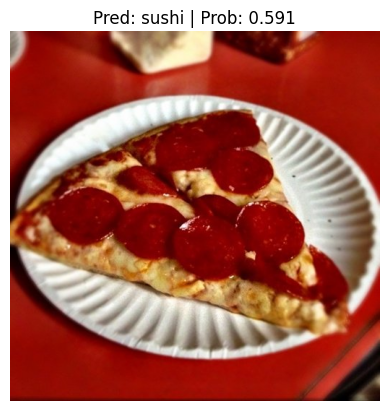

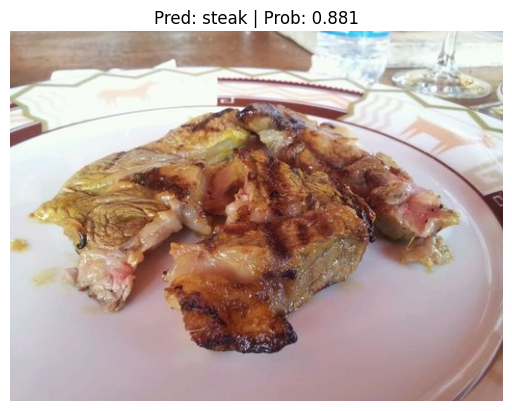

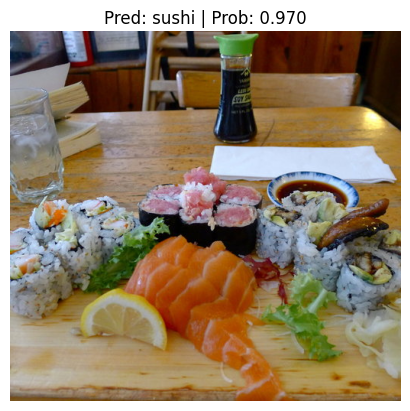

In [36]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

data\04-pizza-dad.jpeg already exists, skipping download.


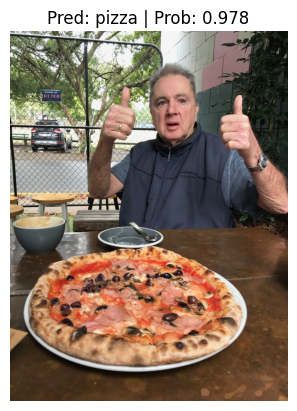

In [32]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)